In [ ]:
# A new environment is recommended:
# conda create -n test_env python numpy h5py xarray rioxarray netCDF4 jupyter matplotlib pandas
# conda activate test_env
# pip install pvlib windpowerlib

# Test of daily PV power production function
## 1. Read one-year climate data

In [1]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import datetime
import re
import gc

import xarray as xr

# set 
# scenario = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
# climate_models = 'ACCESS-ESM1-5'            
# s = 2
year = 2015



#
# Read the variables
#
t = datetime.datetime.now()
tasmax = xr.open_dataset( './data/tasmax_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2015.nc' )['tasmax']
tasmax.coords['lon'] = (tasmax.coords['lon'] + 180) % 360 - 180
tasmax = tasmax.sortby(tasmax.lon) 
tasmax = tasmax.sortby(tasmax.lat, ascending = False) 



tasmin = xr.open_dataset('./data/tasmin_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2015.nc')['tasmin'] 
tasmin.coords['lon'] = (tasmin.coords['lon'] + 180) % 360 - 180
tasmin = tasmin.sortby(tasmin.lon) 
tasmin = tasmin.sortby(tasmin.lat, ascending = False) 



tas = xr.open_dataset('./data/tas_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2015.nc')['tas']   
tas.coords['lon'] = (tas.coords['lon'] + 180) % 360 - 180
tas = tas.sortby(tas.lon) 
tas = tas.sortby(tas.lat, ascending = False) 



rsds = xr.open_dataset( './data/rsds_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2015.nc')['rsds'] 
rsds.coords['lon'] = (rsds.coords['lon'] + 180) % 360 - 180
rsds = rsds.sortby(rsds.lon) 
rsds = rsds.sortby(rsds.lat, ascending = False) 



wind_speed = xr.open_dataset('./data/sfcWind_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2015.nc')['sfcWind'] 
wind_speed.coords['lon'] = (wind_speed.coords['lon'] + 180) % 360 - 180
wind_speed = wind_speed.sortby(wind_speed.lon) 
wind_speed = wind_speed.sortby(wind_speed.lat, ascending = False)   



pixel_type = np.full((len(tasmax.lat), len(tasmax.lon)), 0, dtype = np.int8)
pixel_type[~np.isnan(tasmax[0,:])] = 1


# Extract length info from one file
days = wind_speed.shape[0]
size = wind_speed.shape[1] * wind_speed.shape[2]

# Extract lon/lat info from one file
lat = wind_speed.lat.values
lon = wind_speed.lon.values
lons, lats = np.meshgrid(lon,lat) 
time = wind_speed.time.values

years = [year for i in range(size)]
   
print(year, 'finished: read data', datetime.datetime.now()-t)

2015 finished: read data 0:00:02.860849


## 2. calculate pv power using pvlib.pvsystem.singlediode default

In [2]:
import pv_power_function_2025
# Please note that the input values should be within the reasonable range; otherwise, it may cause overflow. 
# See pvlib.pvsystem.singlediode
# output: ['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx'], default output: 'p_mp'
# power_dc = pvlib.pvsystem.singlediode(IL, I0, Rs, Rsh, nNsVth)['p_mp'] 
quick_pmp = [0 for i in range(size)]
hourly_output = [0 for i in range(size)] 
input_para = np.array(list(zip(pixel_type.reshape(-1).T, 
                       years, 
                       rsds.values.reshape(rsds.shape[0],-1).T, 
                       wind_speed.values.reshape(wind_speed.shape[0],-1).T, 
                       tas.values.reshape(tas.shape[0],-1).T, 
                       tasmin.values.reshape(tasmin.shape[0],-1).T, 
                       tasmax.values.reshape(tasmax.shape[0],-1).T,                         
                       lons.reshape(-1).T, 
                       lats.reshape(-1).T,
                       quick_pmp,
                       hourly_output    
                   )), dtype=object)

t = datetime.datetime.now()
r = pv_power_function_2025.main(input_para[248410,:])
print(datetime.datetime.now() - t )   


0:00:01.000495


Text(0, 0.5, 'Wh/m2')

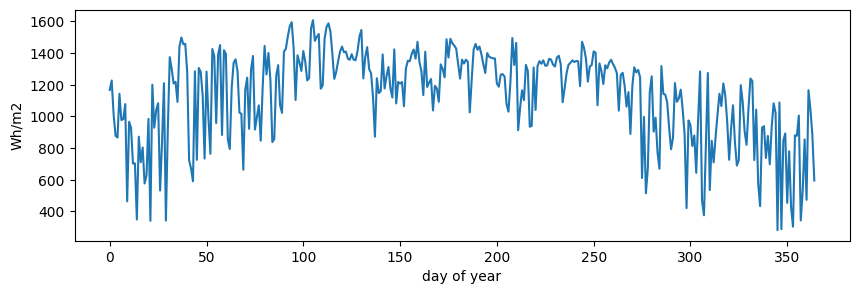

In [3]:
import matplotlib.pyplot as plt
# Here, we can see the daily results.
figure = plt.figure(figsize=(10,3))
plt.plot(r)
plt.xlabel('day of year')
plt.ylabel('Wh/m2')

## 3. calculate pv power using quick_pmp

In [4]:
# quick_pmp = 1:
# only calculate p_mp using bishop88_mpp function
# defalt method: newton
# See pvlib.singlediode.bishop88_mpp
# Compared with default, it will be faster during large-scale runs.
# but the difference between two results is very small in our case.
quick_pmp = [1 for i in range(size)] 
hourly_output = [0 for i in range(size)] 

input_para = np.array(list(zip(pixel_type.reshape(-1).T, 
                       years, 
                       rsds.values.reshape(rsds.shape[0],-1).T, 
                       wind_speed.values.reshape(wind_speed.shape[0],-1).T, 
                       tas.values.reshape(tas.shape[0],-1).T, 
                       tasmin.values.reshape(tasmin.shape[0],-1).T, 
                       tasmax.values.reshape(tasmax.shape[0],-1).T,                         
                       lons.reshape(-1).T, 
                       lats.reshape(-1).T,
                       quick_pmp,
                       hourly_output    
                   )), dtype=object)

# To have a quick run, we choose a point rather than total map
t = datetime.datetime.now()
r = pv_power_function_2025.main(input_para[248410,:])
print(datetime.datetime.now() - t )

0:00:00.617788


Text(0, 0.5, 'Wh/m2')

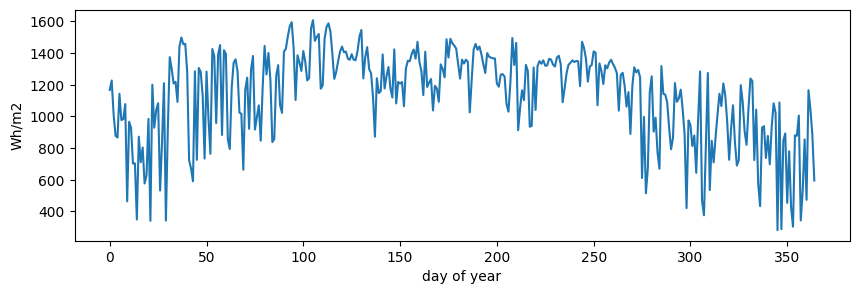

In [5]:
import matplotlib.pyplot as plt
# Here, we can see the daily results.
figure = plt.figure(figsize=(10,3))
plt.plot(r)
plt.xlabel('day of year')
plt.ylabel('Wh/m2')

## 4. calculate pv power and export hourly curve

In [6]:
# if we want to see hourly results (esitimates), we can to set hourly_output = 1
# Please note that our comparison is not based on the output per hour, but rather on the aggregated daily value using hourly input and daily input.
hourly_output = [1 for i in range(size)]
input_para = np.array(list(zip(pixel_type.reshape(-1).T, 
                       years, 
                       rsds.values.reshape(rsds.shape[0],-1).T, 
                       wind_speed.values.reshape(wind_speed.shape[0],-1).T, 
                       tas.values.reshape(tas.shape[0],-1).T, 
                       tasmin.values.reshape(tasmin.shape[0],-1).T, 
                       tasmax.values.reshape(tasmax.shape[0],-1).T,                         
                       lons.reshape(-1).T, 
                       lats.reshape(-1).T,
                       quick_pmp,
                       hourly_output    
                   )), dtype=object)


    
t = datetime.datetime.now()
r = pv_power_function_2025.main(input_para[248410,:])
print(datetime.datetime.now() - t )    

0:00:00.675592


Text(0, 0.5, 'Wh/m2')

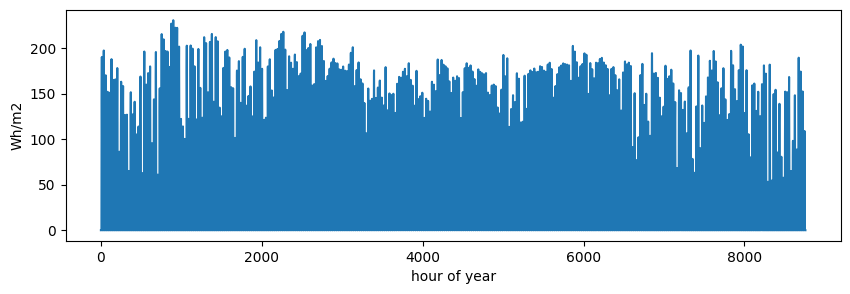

In [7]:
import matplotlib.pyplot as plt
# Here, we can see the hourly results.
figure = plt.figure(figsize=(10,3))
plt.plot(r)
plt.xlabel('hour of year')
plt.ylabel('Wh/m2')

Text(0, 0.5, 'Wh/m2')

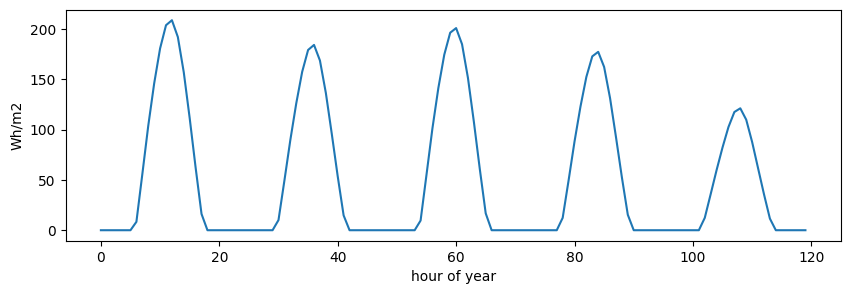

In [8]:
# To see the hourly results for selected 5 days
figure = plt.figure(figsize=(10,3))
plt.plot(r[24*80:24*85])
plt.xlabel('hour of year')
plt.ylabel('Wh/m2')

# Comparison using hourly and daily inputs (PV)
## 1. use hourly data as inputs

In [9]:
import os
import numpy as np
import datetime
import pandas as pd

# Use the ERA5 test data from 2010
data = pd.read_csv('./data/ERA52010_hourly_test.csv')
input_para = np.array((1, 
                       2010, 
                       data['time_UTC'].values,
                       data['rsds'].values, 
                       data['wind_speed'].values, 
                       data['tas'].values,                         
                       2.5,
                       47,                                                      
                       ), dtype=object)


In [10]:
import pv_power_function_hourly

t = datetime.datetime.now()
r_h = pv_power_function_hourly.main(input_para)
print(datetime.datetime.now() - t )   
print('2010 total power production:', r_h.sum())

0:00:02.348746
2010 total power production: 268862.52723092947


Text(0, 0.5, 'Wh/m2')

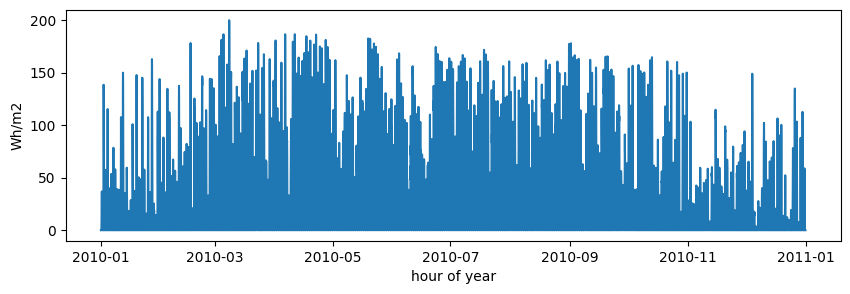

In [11]:
import matplotlib.pyplot as plt
# Here, we can see the hourly results.
figure = plt.figure(figsize=(10,3))
plt.plot(r_h)

plt.xlabel('hour of year')
plt.ylabel('Wh/m2')

Text(0, 0.5, 'Wh/m2')

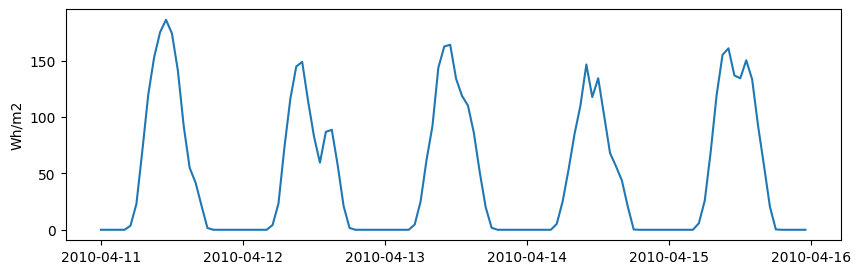

In [12]:
# See the hourly results for 5 days
figure = plt.figure(figsize=(10,3))
plt.plot(r_h[24*100:24*105])
plt.ylabel('Wh/m2')

## 2. use daily data as inputs

In [13]:
import pandas as pd
data = pd.read_csv('./data/ERA52010_daily_test.csv')

import pv_power_function_2025
input_para = np.array((1, 
                       2010,                        
                       data['rsds'].values, 
                       data['wind_speed'].values, 
                       data['tas'].values, 
                       data['tasmin'].values, 
                       data['tasmax'].values, 
                       2.5, 
                       47, 
                       0,
                       1
                       ), dtype=object)

t = datetime.datetime.now()
r_d = pv_power_function_2025.main(input_para)
print(datetime.datetime.now() - t )   
print('2010 total power production:', r_d.sum())

0:00:01.041353
2010 total power production: 262260.72


Text(0, 0.5, 'Wh/m2')

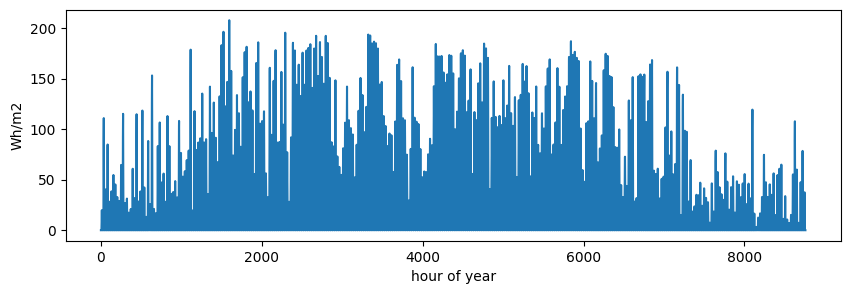

In [14]:
import matplotlib.pyplot as plt
# Here, we can see the hourly results.
figure = plt.figure(figsize=(10,3))
plt.plot(r_d)
plt.xlabel('hour of year')
plt.ylabel('Wh/m2')

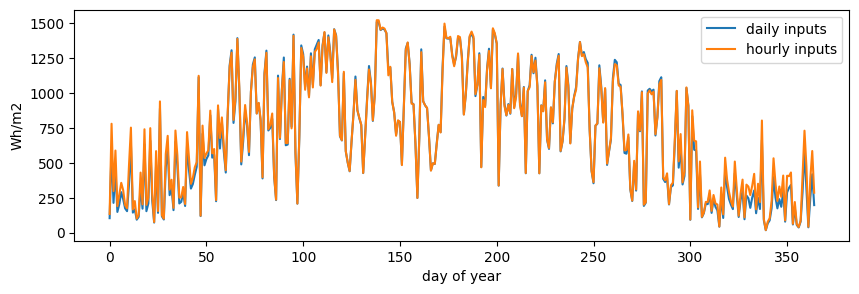

In [15]:
import matplotlib.pyplot as plt
# Here, we can compare the daily power using hourly inputs and daily inputs.
figure = plt.figure(figsize=(10,3))
plt.plot(r_d.reshape(365,24).sum(1), label='daily inputs')
plt.plot(r_h.values.reshape(365,24).sum(1), label='hourly inputs')
plt.xlabel('day of year')
plt.ylabel('Wh/m2')
plt.legend()

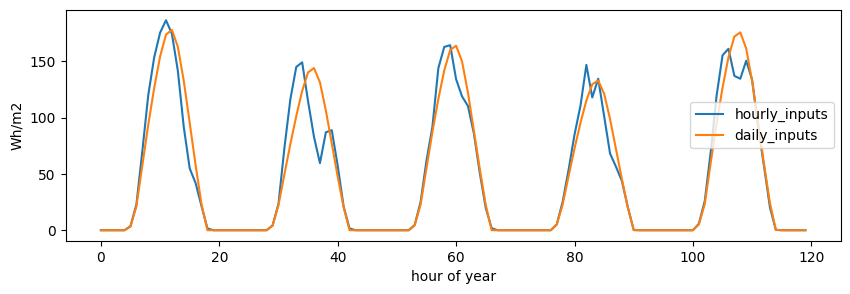

In [16]:
# To see the hourly results for 5 days
# Please note that our comparison is not based on the output per hour, but rather on the aggregated daily value using hourly input and daily input.
figure = plt.figure(figsize=(10,3))
plt.plot(np.array(r_h[24*100:24*105]), label='hourly_inputs') # UTC 0:00
plt.plot(np.array(r_d[24*100:24*105]), label='daily_inputs')
plt.xlabel('hour of year')
plt.ylabel('Wh/m2')
plt.legend()

# Test of daily wind power production function
## 1. Read one-year climate data

In [17]:
import os
import numpy as np
import datetime
import re
import gc
import rioxarray
import xarray as xr

# set 
scenario = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
climate_models = 'ACCESS-ESM1-5'            
s = 2
year = 2015



#
# Read the variables
#
t = datetime.datetime.now()

tas = xr.open_dataset('./data/tas_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2015.nc')['tas']   
tas.coords['lon'] = (tas.coords['lon'] + 180) % 360 - 180
tas = tas.sortby(tas.lon) 
tas = tas.sortby(tas.lat, ascending = False) 

wind_speed = xr.open_dataset('./data/sfcWind_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2015.nc')['sfcWind'] 
wind_speed.coords['lon'] = (wind_speed.coords['lon'] + 180) % 360 - 180
wind_speed = wind_speed.sortby(wind_speed.lon) 
wind_speed = wind_speed.sortby(wind_speed.lat, ascending = False)   



pixel_type = np.full((len(wind_speed.lat), len(wind_speed.lon)), 0, dtype = np.int8)
pixel_type[~np.isnan(wind_speed[0,:])] = 1

# DEM
dem_map = rioxarray.open_rasterio('./data/dem.tif')[0,:]
dem_map.coords['x'] = (dem_map.coords['x'] + 180) % 360 - 180
dem_map = dem_map.sortby(dem_map.x) 
dem_map = dem_map.sel(y = slice(89.75, -60))
dem_map = dem_map.sortby(dem_map.y, ascending = False) 

#
# read power law exponent 
alpha_map = xr.open_dataset('./data/alpha_mean_season_1985-2014.nc')['alpha']
alpha_map = alpha_map.isel(lat=alpha_map.lat > -60)
# expand to daily and hourly  
alpha_map = alpha_map.sel(season = wind_speed["time"].dt.season)
  
print(year, 'finished: read data', datetime.datetime.now()-t)

2015 finished: read data 0:00:01.288747


## 2. calculate wind power

In [18]:
import wind_power_function_2025
input_para = np.array(list(zip(pixel_type.reshape(-1).T, 
                               tas.values.reshape(tas.shape[0],-1).T, 
                               dem_map.values.reshape(-1).T, 
                               wind_speed.values.reshape(wind_speed.shape[0],-1).T, 
                               alpha_map.values.reshape(alpha_map.shape[0],-1).T)), 
                      dtype = object)

# To have a quick run, we choose a point rather than total map
t = datetime.datetime.now()
r = wind_power_function_2025.main(input_para[248410,:])
print(datetime.datetime.now() - t )

0:00:00.121203


Text(0, 0.5, 'W')

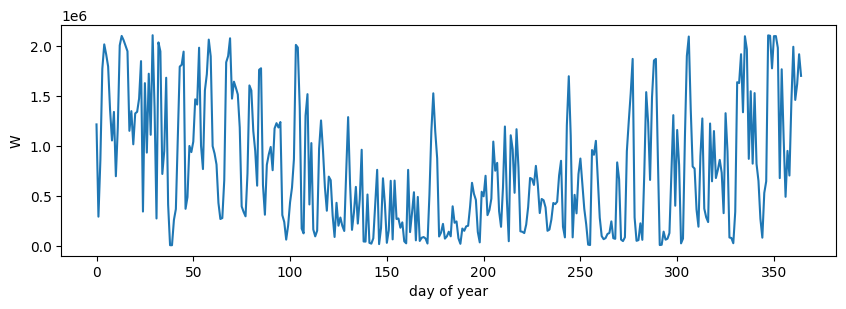

In [19]:
import matplotlib.pyplot as plt
# Here, we can see the daily average results.
figure = plt.figure(figsize=(10,3))
plt.plot(r)
plt.xlabel('day of year')
plt.ylabel('W')

# Comparison using hourly and daily inputs (Wind)
## 1. use hourly data as inputs

In [20]:
import os
import numpy as np
import datetime
import pandas as pd

data = pd.read_csv('./data/ERA52010_hourly_test.csv')
input_para = np.array((1, 
                       data['tas'].values, 
                       255, # DEM
                       data['wind_speed'].values, 
                       data['alpha'].values,                              
                       ), dtype=object)


In [21]:
import wind_power_function_2025

t = datetime.datetime.now()
r_h = wind_power_function_2025.main(input_para)
print(datetime.datetime.now() - t )   
print('2010 average power:', r_h.mean())

0:00:00.774614
2010 average power: 692831.5


Text(0, 0.5, 'W')

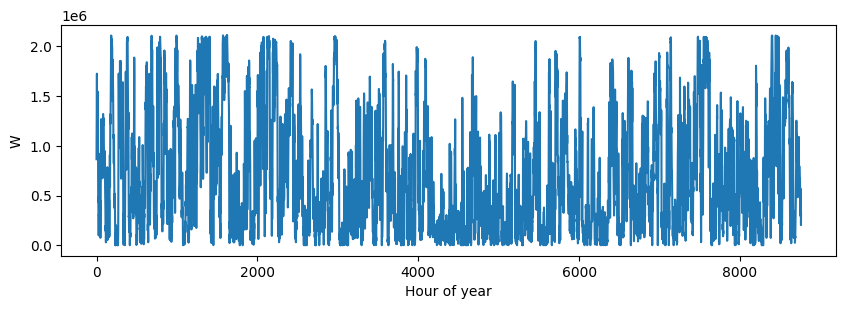

In [22]:
import matplotlib.pyplot as plt
# Here, we can see the hourly results.
figure = plt.figure(figsize=(10,3))
plt.plot(r_h)
plt.xlabel('Hour of year')
plt.ylabel('W')

## 2. use daily data as inputs

In [23]:
import pandas as pd
data = pd.read_csv('./data/ERA52010_daily_test.csv')

import wind_power_function_2025
input_para = np.array((1, 
                       data['tas'].values, 
                       255, # DEM
                       data['wind_speed'].values, 
                       data['alpha'].values,                              
                       ), dtype=object)

t = datetime.datetime.now()
r_d = wind_power_function_2025.main(input_para)
print(datetime.datetime.now() - t )   
print('2010 average power:', r_d.mean())

0:00:00.056135
2010 average power: 687387.44


Text(0, 0.5, 'W')

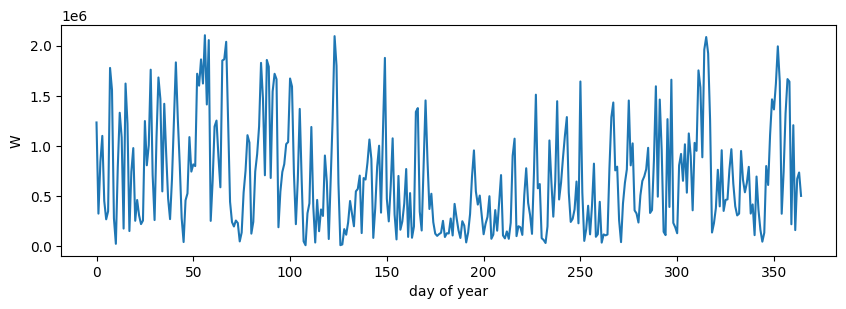

In [24]:
import matplotlib.pyplot as plt
# Here, we can see the hourly results.
figure = plt.figure(figsize=(10,3))
plt.plot(r_d)
plt.xlabel('day of year')
plt.ylabel('W')

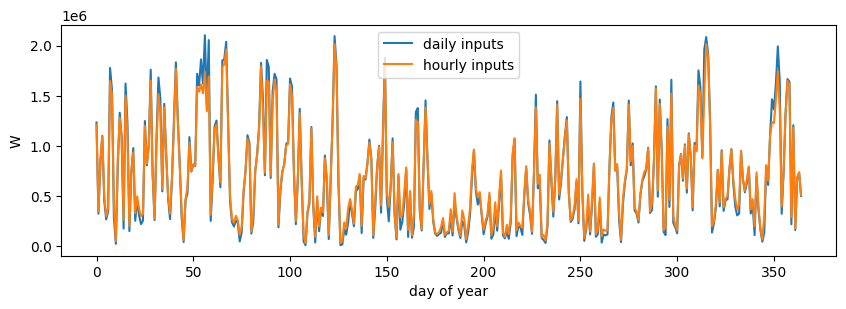

In [25]:
import matplotlib.pyplot as plt
# Here, we can compare the daily power using hourly inputs and daily inputs.
figure = plt.figure(figsize=(10,3))
plt.plot(r_d, label='daily inputs')
plt.plot(r_h.reshape(365,24).mean(1), label='hourly inputs')
plt.xlabel('day of year')
plt.ylabel('W')
plt.legend()